In [1]:
import pennylane as qml
from pennylane import numpy as np

# numpy 
import numpy as np_
import scipy as sp

import matplotlib.pyplot as plt

# 2-qubit
dev = qml.device('default.mixed', wires= 2)

# == Hamiltonian setup == 
coeffs = [1]
obs = [qml.PauliZ(0) @ qml.PauliZ(1)]

hamiltonian = qml.Hamiltonian(coeffs, obs)

In [2]:
# == Generate circuit == 

# global var
    # theta_init, tau_1, tau_2 = paras
    # np.pi/2, 1.653, 0.999
    
Paras_global = 0,0,0
Phi_global = None

# Entnalger 
@qml.qnode(dev)
def circuit_1(paras):
    theta_init, tau_1, tau_2 = paras
    
    # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(hamiltonian, tau_1, 1)
    
    qml.RX(theta_init, wires = 0)    
    qml.RX(theta_init, wires = 1)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   

    qml.ApproxTimeEvolution(hamiltonian, tau_2, 1)

    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    
    return qml.density_matrix(wires=[0, 1])

@qml.qnode(dev)
def circuit_2(phi):
    global Paras_global
    # Get density matrix from circuit_1
    density_matrix = circuit_1(Paras_global)
    qml.QubitDensityMatrix(density_matrix, wires=[0, 1])
    
    # Stage_3: Accumulater
    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    # qml.RX(np.pi/2, wires=0)
    # qml.RX(np.pi/2, wires=1)
    
    # Modified
    qml.RY(-np.pi/2, wires=0)
    qml.RY(-np.pi/2, wires=1)
    
    return qml.density_matrix(wires=[0, 1])

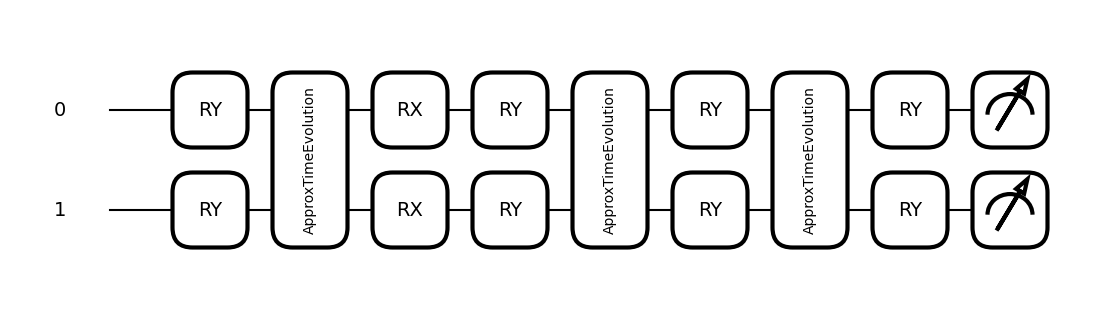

In [3]:
# == Alternative circuit ==

# 1-layer
@qml.qnode(dev)
def circuit_alt(phi):
    theta_init, tau_1, tau_2 = Paras_global[0], Paras_global[1], Paras_global[2]
    
    # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(hamiltonian, tau_1, 1)
    
    qml.RX(theta_init, wires = 0)    
    qml.RX(theta_init, wires = 1)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   

    qml.ApproxTimeEvolution(hamiltonian, tau_2, 1)

    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    
    # Stage_3: Accumulater
    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    
    qml.RY(-np.pi/2, wires=0)
    qml.RY(-np.pi/2, wires=1)
    
    return qml.density_matrix(wires=[0, 1])

fig, ax = qml.draw_mpl(circuit_alt)(0)

In [4]:
# == Post-selection ==

# set gamma_ps 
gamma_ps = 0

@qml.qnode(dev)
def Post_selection(phi):
    # 1.5710033885779824, 1.6535315514712488, 0.9999998668823205
    global Paras_global
    Paras_global = 1.571, 1.653, 0.999

    # Get density matrix from circuit_2
    density_matrix = circuit_2(phi)
    qml.QubitDensityMatrix(density_matrix, wires=[0, 1])
    
    # Kraus operator for 2*2 matrix
    K = np.array([ [np.sqrt(1-gamma_ps), 0], [0, 1] ])
    K_H = K.conj().T
    
    Numerator = sp.linalg.kron(K, K) @ density_matrix @ sp.linalg.kron(K_H, K_H)
    Denominator = np.trace(sp.linalg.kron(K, K) @ density_matrix @ sp.linalg.kron(K_H, K_H))
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires=[0, 1])
    
    # return qml.density_matrix(wires=[0, 1])
    return qml.probs(wires=[0, 1])

# ALT
@qml.qnode(dev)
def Post_selection_alt(phi):
    # 1.5710033885779824, 1.6535315514712488, 0.9999998668823205

    global Paras_global
    Paras_global = 1.571, 1.653, 0.999
    
    # Get density matrix from circuit_2
    density_matrix = circuit_alt(phi)
    qml.QubitDensityMatrix(density_matrix, wires=[0, 1])
    
    # Kraus operator for 2*2 matrix
    K = np.array([ [np.sqrt(1-gamma_ps), 0], [0, 1] ])
    K_H = K.conj().T
    
    Numerator = sp.linalg.kron(K, K) @ density_matrix @ sp.linalg.kron(K_H, K_H)
    Denominator = np.trace(sp.linalg.kron(K, K) @ density_matrix @ sp.linalg.kron(K_H, K_H))
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires=[0, 1])
    
    return qml.density_matrix(wires=[0, 1])
    # return qml.probs(wires=[0, 1])

In [5]:
# == Test CFI at ceratin point ==
phi_sel = np.array([8])

gamma_ps = 0.9
CFI_P = qml.qinfo.classical_fisher(Post_selection)(phi_sel)

type(CFI_P)

numpy.ndarray

In [6]:
# == Variables define for plot ==

# Sweep boundaries
Select_bound = np_.array([1e-4, np.pi * 4 + 1e-4])

Numerator_of_N = (Select_bound[1] - Select_bound[0])

N = int((Numerator_of_N / np.pi) * 31)
# N = 100

step_size_cal = Numerator_of_N / N

# == pi / 31 ==
# Optimal step size = 0.10134169850289655

# gamma
gamma_0, gamma_1, gamma_2 = 0.2, 0.7, 0.9


# Print out status
print('Optimal step-size for arange:', step_size_cal, '\nN:', N)
print('gamma:', gamma_0, gamma_1, gamma_2)

Optimal step-size for arange: 0.10134169850289655 
N: 124
gamma: 0.2 0.7 0.9


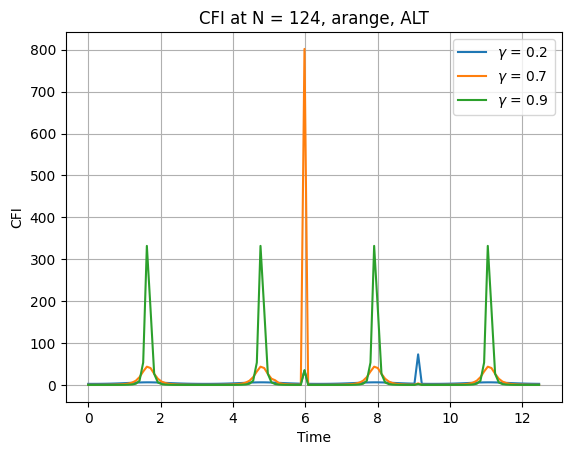

In [7]:
# == Alt circuit ==
# == Plot using np.arange

# defined as original numpy array!!
Select_bound = np_.array([1e-4, np.pi * 4 + 1e-4])

Step_size = (Select_bound[1] - Select_bound[0]) / N
# ** Optimal step size found: 0.10134169850289655 vs 0.12566370614359174; at N = 100
# Step_size = 0.10134169850289655 

# Searching range array
Phi_range = np.arange(Select_bound[0], Select_bound[1], Step_size)
CFI_0 = np.zeros(len(Phi_range))
CFI_1 = np.zeros(len(Phi_range))
CFI_2 = np.zeros(len(Phi_range))

for i in range(len(Phi_range)):
    
    gamma_ps = gamma_0
    CFI_0[i] = qml.qinfo.classical_fisher(Post_selection_alt)(Phi_range[i])
    
    gamma_ps = gamma_1
    CFI_1[i] = qml.qinfo.classical_fisher(Post_selection_alt)(Phi_range[i])
    
    gamma_ps = gamma_2
    CFI_2[i] = qml.qinfo.classical_fisher(Post_selection_alt)(Phi_range[i])

# Plot CFI_before
plt.plot(Phi_range, CFI_0, label = f'$\gamma$ = {gamma_0}')
plt.plot(Phi_range, CFI_1, label = f'$\gamma$ = {gamma_1}')
plt.plot(Phi_range, CFI_2, label = f'$\gamma$ = {gamma_2}')
plt.title(f'CFI at N = {N}, arange, ALT')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid()

In [8]:
# == Alt circuit ==
# == Plot using np.arange

# defined as original numpy array!!
Select_bound = np_.array([1e-4, np.pi * 4 + 1e-4])

Step_size = (Select_bound[1] - Select_bound[0]) / N
# ** Optimal step size found: 0.10134169850289655 vs 0.12566370614359174; at N = 100
# Step_size = 0.10134169850289655 

# Searching range array
Phi_range = np.arange(Select_bound[0], Select_bound[1], Step_size)
CFI_0 = np.zeros(len(Phi_range))
CFI_1 = np.zeros(len(Phi_range))
CFI_2 = np.zeros(len(Phi_range))

CFI = [[0 for j in range(len(Phi_range))] for i in range(3)]

for i in range(3):
    for j in range(len(Phi_range)):
        if i == 0

for i in range(3):
    for j in range(len(Phi_range)):
        print(CFI[i][j], end=" ")
    print()    
        
# for i in range(len(Phi_range)):
    
#     gamma_ps = gamma_0
#     CFI_0[i] = qml.qinfo.classical_fisher(Post_selection_alt)(Phi_range[i])
    
#     gamma_ps = gamma_1
#     CFI_1[i] = qml.qinfo.classical_fisher(Post_selection_alt)(Phi_range[i])
    
#     gamma_ps = gamma_2
#     CFI_2[i] = qml.qinfo.classical_fisher(Post_selection_alt)(Phi_range[i])

# # Plot CFI_before
# plt.plot(Phi_range, CFI_0, label = f'$\gamma$ = {gamma_0}')
# plt.plot(Phi_range, CFI_1, label = f'$\gamma$ = {gamma_1}')
# plt.plot(Phi_range, CFI_2, label = f'$\gamma$ = {gamma_2}')
# plt.title(f'CFI at N = {N}, arange, ALT')
# plt.xlabel('Time')
# plt.ylabel('CFI')
# plt.legend()
# plt.grid()

SyntaxError: expected ':' (3853475292.py, line 21)

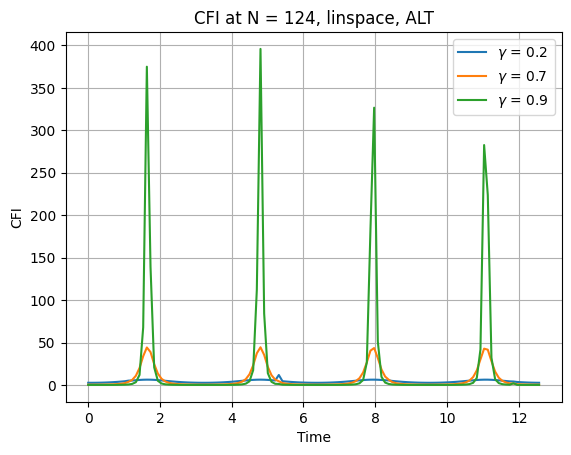

In [ ]:
# == ALT circuit
# Plot using np.linspace

# Searching range array
Phi_range = np.linspace(Select_bound[0], Select_bound[1], N)
CFI_0 = np.zeros(len(Phi_range))
CFI_1 = np.zeros(len(Phi_range))
CFI_2 = np.zeros(len(Phi_range))


for i in range(len(Phi_range)):
    
    gamma_ps = gamma_0
    CFI_0[i] = qml.qinfo.classical_fisher(Post_selection_alt)(Phi_range[i])
    
    gamma_ps = gamma_1
    CFI_1[i] = qml.qinfo.classical_fisher(Post_selection_alt)(Phi_range[i])
    
    gamma_ps = gamma_2
    CFI_2[i] = qml.qinfo.classical_fisher(Post_selection_alt)(Phi_range[i])

# Plot CFI_before
plt.plot(Phi_range, CFI_0, label = f'$\gamma$ = {gamma_0}')
plt.plot(Phi_range, CFI_1, label = f'$\gamma$ = {gamma_1}')
plt.plot(Phi_range, CFI_2, label = f'$\gamma$ = {gamma_2}')
# plt.title(f'$\CFI$ {N}')
plt.title(f'CFI at N = {N}, linspace, ALT')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid()

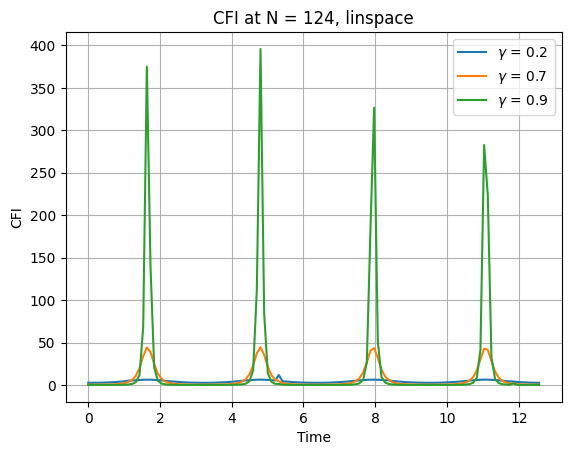

In [ ]:
# Plot using np.linspace

# Alt approach to calculate N

# Searching range array
Phi_range = np.linspace(Select_bound[0], Select_bound[1], N)
CFI_0 = np.zeros(len(Phi_range))
CFI_1 = np.zeros(len(Phi_range))
CFI_2 = np.zeros(len(Phi_range))


for i in range(len(Phi_range)):
    
    gamma_ps = gamma_0
    CFI_0[i] = qml.qinfo.classical_fisher(Post_selection)(Phi_range[i])
    
    gamma_ps = gamma_1
    CFI_1[i] = qml.qinfo.classical_fisher(Post_selection)(Phi_range[i])
    
    gamma_ps = gamma_2
    CFI_2[i] = qml.qinfo.classical_fisher(Post_selection)(Phi_range[i])

# Plot CFI_before
plt.plot(Phi_range, CFI_0, label = f'$\gamma$ = {gamma_0}')
plt.plot(Phi_range, CFI_1, label = f'$\gamma$ = {gamma_1}')
plt.plot(Phi_range, CFI_2, label = f'$\gamma$ = {gamma_2}')
# plt.title(f'$\CFI$ {N}')
plt.title(f'CFI at N = {N}, linspace')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid()

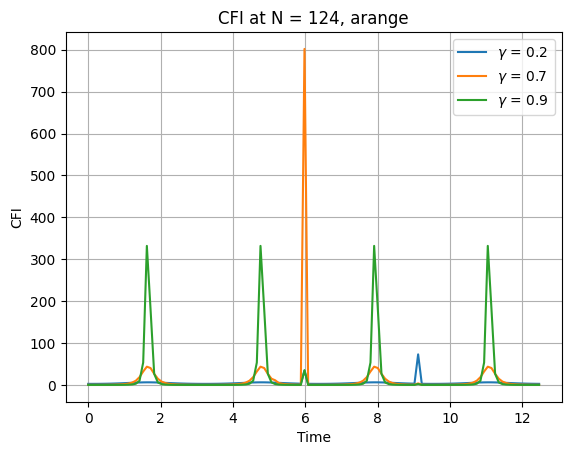

In [ ]:
# == Plot using np.arange

# defined as original numpy array!!
Select_bound = np_.array([1e-4, np.pi * 4 + 1e-4])

Step_size = (Select_bound[1] - Select_bound[0]) / N
# ** Optimal step size found: 0.10134169850289655
# Step_size = 0.10134169850289655 

# Searching range array
Phi_range = np.arange(Select_bound[0], Select_bound[1], Step_size)
CFI_0 = np.zeros(len(Phi_range))
CFI_1 = np.zeros(len(Phi_range))
CFI_2 = np.zeros(len(Phi_range))

for i in range(len(Phi_range)):
    
    gamma_ps = gamma_0
    CFI_0[i] = qml.qinfo.classical_fisher(Post_selection)(Phi_range[i])
    
    gamma_ps = gamma_1
    CFI_1[i] = qml.qinfo.classical_fisher(Post_selection)(Phi_range[i])
    
    gamma_ps = gamma_2
    CFI_2[i] = qml.qinfo.classical_fisher(Post_selection)(Phi_range[i])

# Plot CFI_before
plt.plot(Phi_range, CFI_0, label = f'$\gamma$ = {gamma_0}')
plt.plot(Phi_range, CFI_1, label = f'$\gamma$ = {gamma_1}')
plt.plot(Phi_range, CFI_2, label = f'$\gamma$ = {gamma_2}')
plt.title(f'CFI at N = {N}, arange')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid()

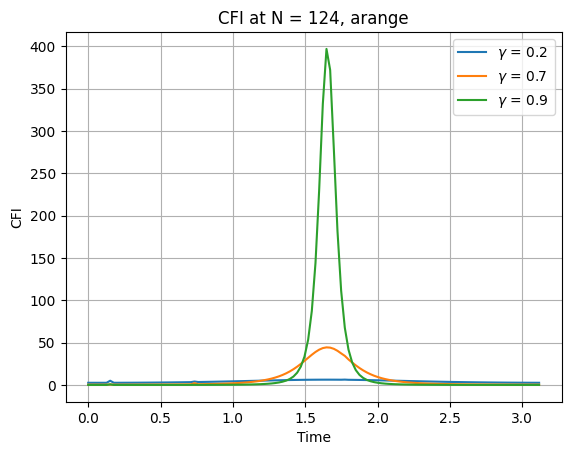

In [ ]:
# == Sweep for [0, pi] ==

# defined as original numpy array!!
Select_bound = np_.array([1e-4, np.pi * 1 + 1e-4])

# Step_size = (Select_bound[1] - Select_bound[0]) / N
# ** Optimal step size found: 0.10134169850289655
Step_size = (Select_bound[1] - Select_bound[0]) / N


# Searching range array
Phi_range = np.arange(Select_bound[0], Select_bound[1], Step_size)
CFI_0 = np.zeros(len(Phi_range))
CFI_1 = np.zeros(len(Phi_range))
CFI_2 = np.zeros(len(Phi_range))

for i in range(len(Phi_range)):
    
    gamma_ps = gamma_0
    CFI_0[i] = qml.qinfo.classical_fisher(Post_selection)(Phi_range[i])
    
    gamma_ps = gamma_1
    CFI_1[i] = qml.qinfo.classical_fisher(Post_selection)(Phi_range[i])
    
    gamma_ps = gamma_2
    CFI_2[i] = qml.qinfo.classical_fisher(Post_selection)(Phi_range[i])

# Plot CFI_before
plt.plot(Phi_range, CFI_0, label = f'$\gamma$ = {gamma_0}')
plt.plot(Phi_range, CFI_1, label = f'$\gamma$ = {gamma_1}')
plt.plot(Phi_range, CFI_2, label = f'$\gamma$ = {gamma_2}')
plt.title(f'CFI at N = {N}, arange')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid()

0.12566370614359174


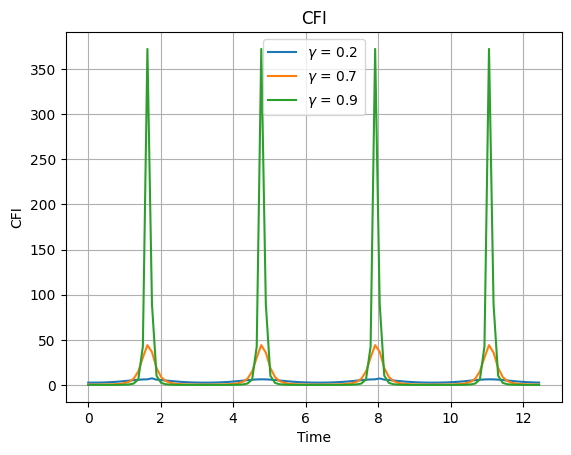

In [ ]:
# Plot using original numpy

# == Plot using np.arange

Select_bound = np_.array([1e-4, np.pi * 4 + 1e-4])
# Step_size = (Select_bound[1] - Select_bound[0]) / N
# Step_size = 0.12566371

# ** Optimal step size found: 0.10134169850289655
Step_size = 0.12566370614359174

# Searching range array
Phi_range = np.arange(Select_bound[0], Select_bound[1], Step_size)
CFI_0 = np_.zeros(len(Phi_range))
CFI_1 = np_.zeros(len(Phi_range))
CFI_2 = np_.zeros(len(Phi_range))

for i in range(len(Phi_range)):
    
    gamma_ps = gamma_0
    CFI_0[i] = qml.qinfo.classical_fisher(Post_selection)(Phi_range[i])
    
    gamma_ps = gamma_1
    CFI_1[i] = qml.qinfo.classical_fisher(Post_selection)(Phi_range[i])
    
    gamma_ps = gamma_2
    CFI_2[i] = qml.qinfo.classical_fisher(Post_selection)(Phi_range[i])

# Plot CFI_before
plt.plot(Phi_range, CFI_0, label = f'$\gamma$ = {gamma_0}')
plt.plot(Phi_range, CFI_1, label = f'$\gamma$ = {gamma_1}')
plt.plot(Phi_range, CFI_2, label = f'$\gamma$ = {gamma_2}')
plt.title('CFI')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid()

print(Step_size )

In [ ]:
Select_bound = np_.array([1e-4, np.pi * 4 + 1e-4])
Step_size = (Select_bound[1] - Select_bound[0]) / N

Phi_range = np.arange(Select_bound[0], Select_bound[1], Step_size)
Phi_range_ = np_.arange(Select_bound[0], Select_bound[1], Step_size)

Phi_range

tensor([1.00000000e-04, 1.01441699e-01, 2.02783397e-01, 3.04125096e-01,
        4.05466794e-01, 5.06808493e-01, 6.08150191e-01, 7.09491890e-01,
        8.10833588e-01, 9.12175287e-01, 1.01351699e+00, 1.11485868e+00,
        1.21620038e+00, 1.31754208e+00, 1.41888378e+00, 1.52022548e+00,
        1.62156718e+00, 1.72290887e+00, 1.82425057e+00, 1.92559227e+00,
        2.02693397e+00, 2.12827567e+00, 2.22961737e+00, 2.33095907e+00,
        2.43230076e+00, 2.53364246e+00, 2.63498416e+00, 2.73632586e+00,
        2.83766756e+00, 2.93900926e+00, 3.04035096e+00, 3.14169265e+00,
        3.24303435e+00, 3.34437605e+00, 3.44571775e+00, 3.54705945e+00,
        3.64840115e+00, 3.74974284e+00, 3.85108454e+00, 3.95242624e+00,
        4.05376794e+00, 4.15510964e+00, 4.25645134e+00, 4.35779304e+00,
        4.45913473e+00, 4.56047643e+00, 4.66181813e+00, 4.76315983e+00,
        4.86450153e+00, 4.96584323e+00, 5.06718493e+00, 5.16852662e+00,
        5.26986832e+00, 5.37121002e+00, 5.47255172e+00, 5.573893

In [ ]:
Phi_range_

array([1.00000000e-04, 1.01441699e-01, 2.02783397e-01, 3.04125096e-01,
       4.05466794e-01, 5.06808493e-01, 6.08150191e-01, 7.09491890e-01,
       8.10833588e-01, 9.12175287e-01, 1.01351699e+00, 1.11485868e+00,
       1.21620038e+00, 1.31754208e+00, 1.41888378e+00, 1.52022548e+00,
       1.62156718e+00, 1.72290887e+00, 1.82425057e+00, 1.92559227e+00,
       2.02693397e+00, 2.12827567e+00, 2.22961737e+00, 2.33095907e+00,
       2.43230076e+00, 2.53364246e+00, 2.63498416e+00, 2.73632586e+00,
       2.83766756e+00, 2.93900926e+00, 3.04035096e+00, 3.14169265e+00,
       3.24303435e+00, 3.34437605e+00, 3.44571775e+00, 3.54705945e+00,
       3.64840115e+00, 3.74974284e+00, 3.85108454e+00, 3.95242624e+00,
       4.05376794e+00, 4.15510964e+00, 4.25645134e+00, 4.35779304e+00,
       4.45913473e+00, 4.56047643e+00, 4.66181813e+00, 4.76315983e+00,
       4.86450153e+00, 4.96584323e+00, 5.06718493e+00, 5.16852662e+00,
       5.26986832e+00, 5.37121002e+00, 5.47255172e+00, 5.57389342e+00,
      

In [ ]:
CFI_0



array([2.57244189, 2.5634973 , 2.61309292, 2.72309026, 2.89726637,
       3.14050696, 3.45717364, 3.84817776, 4.30640043, 4.81076515,
       5.3208707 , 5.77633319, 6.10587202, 6.24737101, 7.33206215,
       5.89407726, 5.46960991, 4.96905344, 4.45765043, 3.98222293,
       3.56932125, 3.22968412, 2.96429765, 2.76947497, 2.64026709,
       2.57244189, 2.5634973 , 2.61309292, 2.72309026, 2.89726637,
       3.14050696, 3.45717364, 3.84817776, 4.30640043, 4.81076515,
       5.3208707 , 5.77633319, 6.10587202, 6.24737101, 6.17145892,
       5.89407726, 5.46960991, 4.96905344, 4.45765043, 3.98222293,
       3.56932125, 3.22968412, 2.96429765, 2.76947497, 2.64026709,
       2.57244189, 2.5634973 , 2.61309292, 2.72309026, 2.89726637,
       3.14050696, 3.45717364, 3.84817776, 4.30640043, 4.81076515,
       5.3208707 , 5.77633319, 6.10587202, 6.24737101, 7.19656255,
       5.89407726, 5.46960991, 4.96905344, 4.45765043, 3.98222293,
       3.56932125, 3.22968412, 2.96429765, 2.76947497, 2.64026

In [ ]:
Phi_range

tensor([1.00000000e-04, 1.01441699e-01, 2.02783397e-01, 3.04125096e-01,
        4.05466794e-01, 5.06808493e-01, 6.08150191e-01, 7.09491890e-01,
        8.10833588e-01, 9.12175287e-01, 1.01351699e+00, 1.11485868e+00,
        1.21620038e+00, 1.31754208e+00, 1.41888378e+00, 1.52022548e+00,
        1.62156718e+00, 1.72290887e+00, 1.82425057e+00, 1.92559227e+00,
        2.02693397e+00, 2.12827567e+00, 2.22961737e+00, 2.33095907e+00,
        2.43230076e+00, 2.53364246e+00, 2.63498416e+00, 2.73632586e+00,
        2.83766756e+00, 2.93900926e+00, 3.04035096e+00, 3.14169265e+00,
        3.24303435e+00, 3.34437605e+00, 3.44571775e+00, 3.54705945e+00,
        3.64840115e+00, 3.74974284e+00, 3.85108454e+00, 3.95242624e+00,
        4.05376794e+00, 4.15510964e+00, 4.25645134e+00, 4.35779304e+00,
        4.45913473e+00, 4.56047643e+00, 4.66181813e+00, 4.76315983e+00,
        4.86450153e+00, 4.96584323e+00, 5.06718493e+00, 5.16852662e+00,
        5.26986832e+00, 5.37121002e+00, 5.47255172e+00, 5.573893